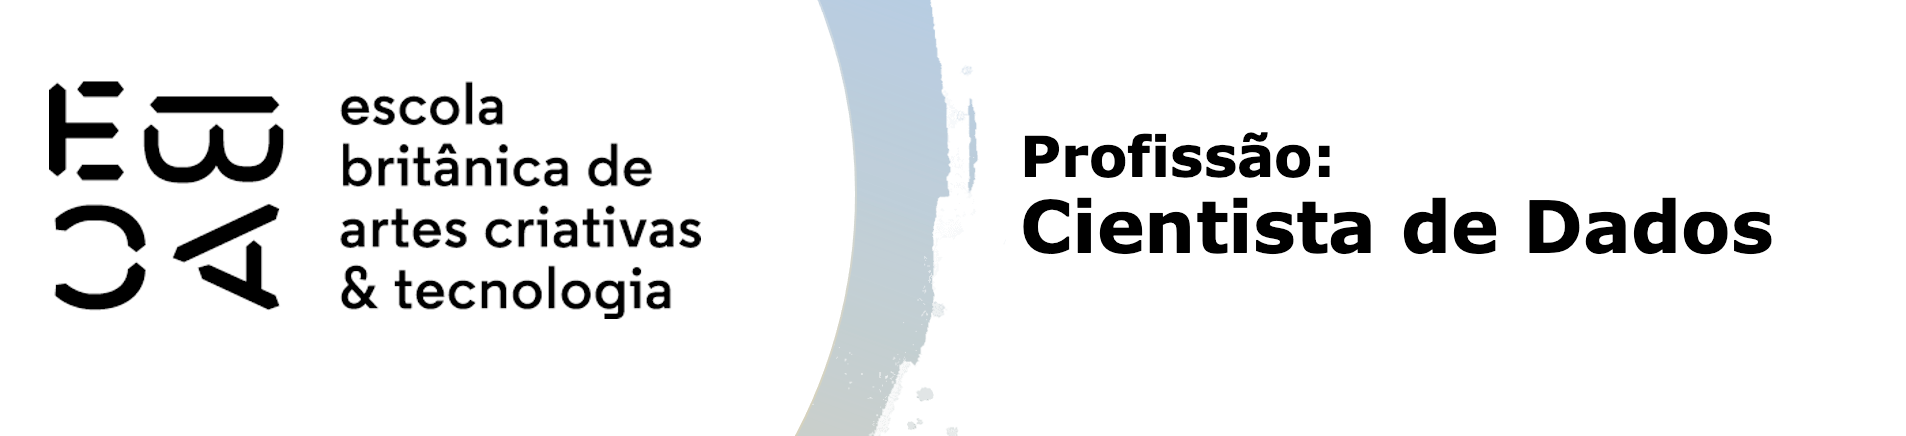

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

import scipy.stats as ss 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import patsy
import statsmodels.api as sm

from scipy.interpolate import interp1d
import warnings;   warnings.filterwarnings("ignore")

df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [2]:
# Identificando valores missing
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


In [3]:
df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [4]:
# Substituindo os valores missing pela média

df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean(), inplace=True)

In [5]:
df.isnull().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [6]:
# Separando bases de treino e teste baseado na data

df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]

# Criando as variáveis log_renda

df_train['log_renda']=np.log(df_train['renda'])
df_test['log_renda']=np.log(df_test['renda'])

In [7]:
# No módulo passado já obtivemos um modelo com 4 variáveis explicativas através da regressão LASSO 

X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego
                    + 1''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                 1.103e+05
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:32:25   Log-Likelihood:            -8.0490e+05
No. Observations:              600000   AIC:                         1.610e+06
Df Residuals:                  599996   BIC:                         1.610e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.3826      0.005   1693.373      0.000       8.373       8.392
C(posse_de_imovel)[T.S]     0.1790      0.003     69.703      0.000       0.174       0.184
qtd_filhos                       0          0        nan        nan           0           0
idade                      -0.0056      0.000    -50.285      0.000      -0.006      -0.005
tempo_emprego               0.1317      0.000    650.147      0.000       0.131       0.132
==============================================================================
Omnibus:                      891.428   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              795.178
Skew:                          -0.048   Prob(JB):                    2.13e-173
Kurtosis:                       2.850   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Aparentemente podemos até retirar mais uma variável do modelo pois o R² não se alterou

# Irei remover a variável idade também, pois representa um coeficiente muito pequeno comparado com as outras variáveis

X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                    + tempo_emprego
                    + 1''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.456e+05
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:32:30   Log-Likelihood:            -8.0617e+05
No. Observations:              600000   AIC:                         1.612e+06
Df Residuals:                  599997   BIC:                         1.612e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.1700      0.003   3166.772      0.000       8.165       8.175
C(posse_de_imovel)[T.S]     0.1615      0.003     63.353      0.000       0.157       0.167
tempo_emprego               0.1291      0.000    657.553      0.000       0.129       0.129
==============================================================================
Omnibus:                      863.676   Durbin-Watson:                   1.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.991
Skew:                          -0.048   Prob(JB):                    8.51e-169
Kurtosis:                       2.853   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

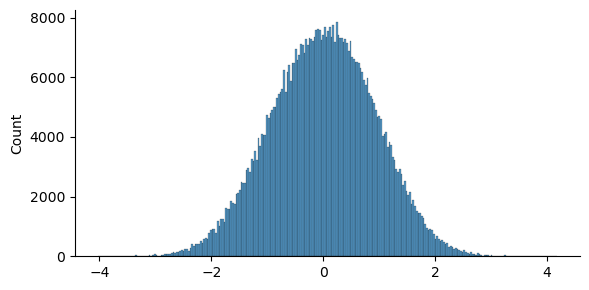

In [9]:
# Vamos analisar os resíduos

sns.displot(res.resid, height=3, aspect=2);

<Axes: ylabel='log_renda'>

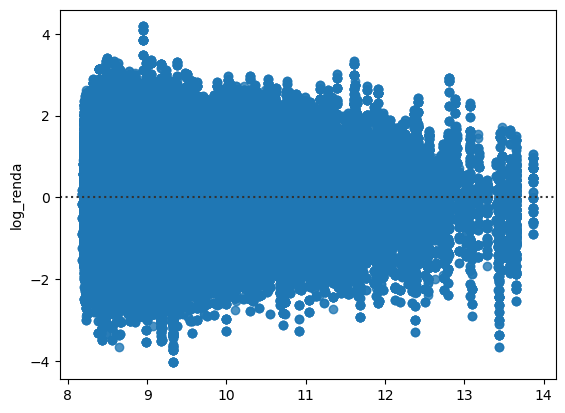

In [10]:
sns.residplot(x=res.predict(), y='log_renda', data=df_train)

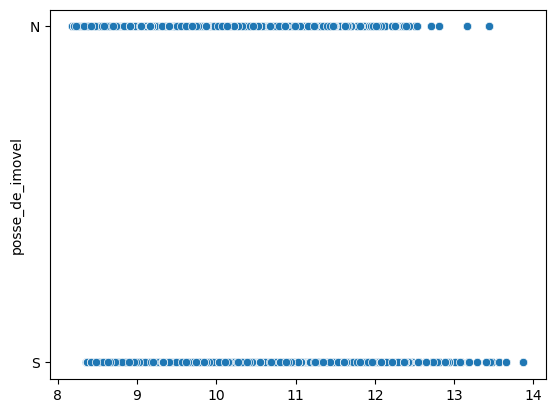

In [11]:
sns.scatterplot(x = res.predict(), y = 'posse_de_imovel', data=df_train);

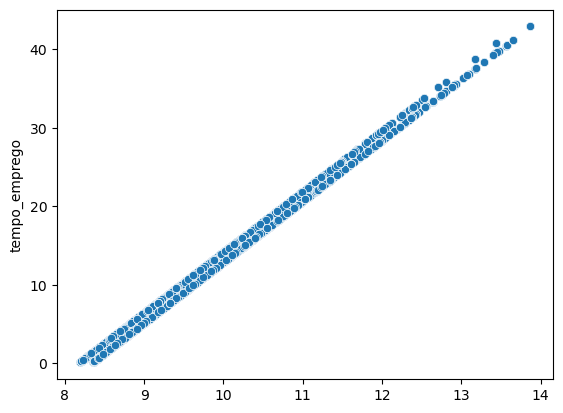

In [12]:
sns.scatterplot(x = res.predict(), y = 'tempo_emprego', data=df_train);

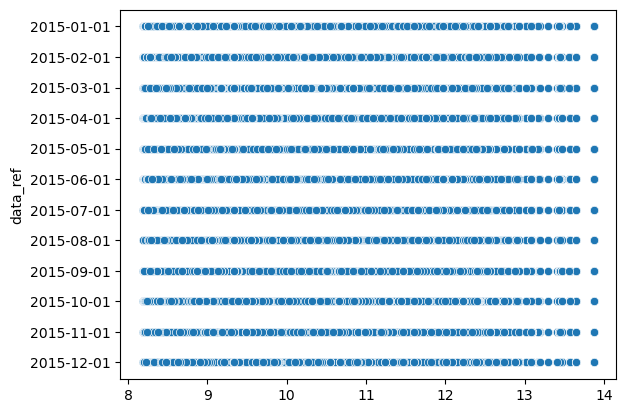

In [13]:
sns.scatterplot(x = res.predict(), y = 'data_ref', data=df_train);

<Axes: >

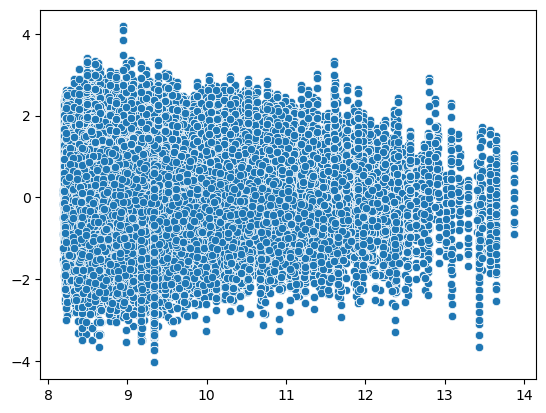

In [14]:
sns.scatterplot(x = res.predict(), y = res.resid)

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [15]:

df_train_short = df_train[:'2015-02-01']
df_train_short.reset_index(inplace=True)
df_train_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               100000 non-null  object 
 1   index                  100000 non-null  int64  
 2   sexo                   100000 non-null  object 
 3   posse_de_veiculo       100000 non-null  object 
 4   posse_de_imovel        100000 non-null  object 
 5   qtd_filhos             100000 non-null  int64  
 6   tipo_renda             100000 non-null  object 
 7   educacao               100000 non-null  object 
 8   estado_civil           100000 non-null  object 
 9   tipo_residencia        100000 non-null  object 
 10  idade                  100000 non-null  int64  
 11  tempo_emprego          100000 non-null  float64
 12  qt_pessoas_residencia  100000 non-null  float64
 13  renda                  100000 non-null  float64
 14  log_renda              100000 non-nul

In [16]:
reg = smf.ols('log_renda ~ tempo_emprego', data=df_train_short).fit()

In [ ]:
%%time

fig = sm.graphics.influence_plot(reg, criterion="cooks")
fig.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [ ]:
df_train_cut = df_train[['posse_de_imovel', 'tempo_emprego', 'log_renda']]

df_train_cut.head(2)

In [ ]:
# Matriz de correlação de Spearman

df_train_cut.corr(method='spearman')


In [ ]:
# VIF

variaveis = ['tempo_emprego', 'posse_de_imovel']

dum = pd.get_dummies(df_train_cut[variaveis], drop_first=True)
dum.head(2)

In [ ]:
vif(dum.values, 1)

In [ ]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(dum, i) for i in range(dum.shape[1])]
vars_vif["Feature"] = dum.columns

vars_vif.round(2)

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.